In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from utils.forward_op import model
from utils.data_import import load_observations

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 10]

4


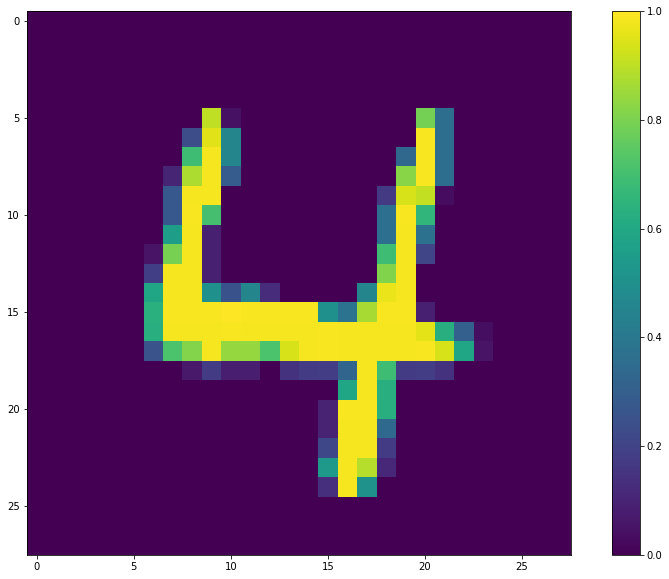

In [2]:
probs = .5
size = 28
shape = (size,)*2
length = size**2

images, labels = load_observations()
sample_idx = 42
sample_image = images.iloc[sample_idx].to_numpy().reshape(-1, size, size, 1)
sample_label = labels.iloc[sample_idx].to_numpy().reshape(-1, 10)
print(sample_label.argmax())
plt.imshow(sample_image[0,:,:,0])
plt.colorbar()

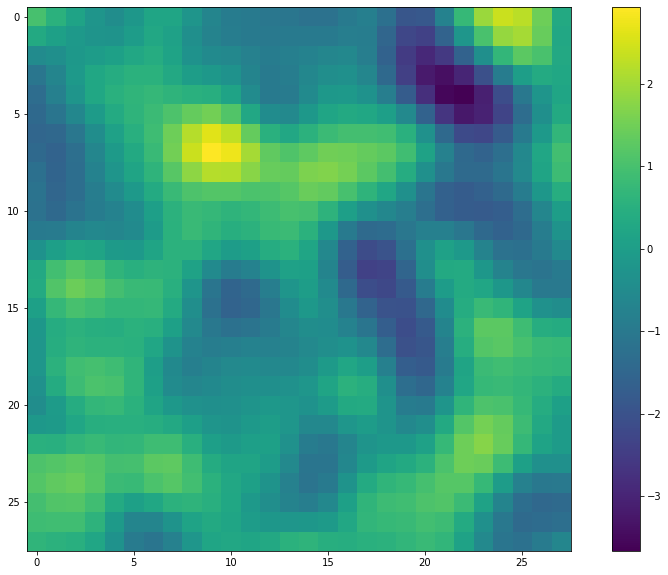

In [5]:
class GPPrior(object):
    def __init__(self, shape=shape):
        self.batch_size = 4
        self.length = np.product(shape)
        self.batch_shape = (self.batch_size, ) + shape + (1,)

        self.index_points = np.indices(shape, dtype=np.float32).reshape(2, self.length).T / shape[0]
        
        self.kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(1, .08, 1)
        
        km = self.kernel.tensor(self.index_points, self.index_points, 1, 1) + 1e-4*tf.eye(length)
        self.sigma = tf.linalg.cholesky(km)
        
        self.base_distribution = tfd.MultivariateNormalDiag(loc=0., scale_diag=tf.ones(self.length))
    
    def sample(self):
        sample = self.base_distribution.sample(self.batch_size)
        return tf.reshape(
            tf.einsum("ij, kj -> ki", self.sigma, sample), 
            self.batch_shape
        )

prior = GPPrior()
s = prior.sample()
plt.imshow(s[0, :, :, 0].numpy())
plt.colorbar()

In [6]:
# predict as 1, but image displays 4
target_label = tf.constant([[0., 1., 0., 0., 0, 0., 0., 0., 0., 0.]])

# reweighting prediction results vs loss
weights = tf.constant([size**2/(size**2 + 10), 10/(size**2 + 10)])

def loss(image_batch, target_image=sample_image[0,:,:], target_label=target_label, weights=weights):
    'Calculate loss, currently a linear combination of prediction error and deviation from image'
    pred_loss = tf.reduce_sum((model.predict(image_batch) - target_label)**2, axis=1)
    image_loss = tf.reduce_sum((image_batch - target_image)**2, axis=(1,2,3))
    return weights[0] * tf.reduce_mean(pred_loss) + weights[1] * tf.reduce_mean(image_loss)

print(loss(s))

tf.Tensor(12.956993, shape=(), dtype=float32)


In [7]:
# MCMC Sampling, in particular, we are using the pCN algorithm. 
# Modified from Alexander Nenninger's Bachelor's Thesis.

n_samples = 5*10**4
beta = 0.01

chain = []
acc = []
betas = []
xi = prior.sample()
for i in range(n_samples):
    xi_hat = tf.sqrt(1. - beta**2) * xi + beta * prior.sample()
    log_prob = tf.minimum(loss(xi) - loss(xi_hat), 0)
    if tfd.Uniform().sample(1) <= tf.exp(log_prob):
        xi = xi_hat
        acc.append(True)
    else:
        acc.append(False)
    chain.append(xi)
    #beta update such that the acceptance rate stays around .23
    beta += .001 * (tf.exp(log_prob) - .23)
    beta = tf.clip_by_value(beta, 1e-15, 1 - 1e-15)
    betas.append(beta)

0.4957
[1 1 1 1]


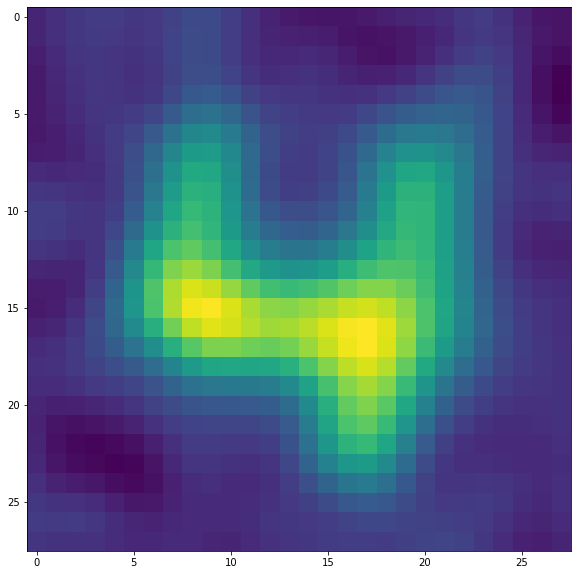

In [8]:
result = tf.reduce_mean(chain, axis=(0))
acc_prob = np.mean(acc)
print(acc_prob)
print(model.predict(result).argmax(axis=1))
plt.imshow(result.numpy().mean(axis=(0,-1)))

In [10]:
model.predict(result).argmax(axis=-1)

array([1, 1, 1, 1], dtype=int64)

In [9]:
model.predict(result.numpy().mean(axis=0).reshape(1,28,28,1)).argmax(axis=-1)

array([1])

In [10]:
model.predict(result).argmax(axis=-1)

array([1, 1, 1, 1])